## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from utils import dummify_dataframe , calculate_clv
from Exponential import ExponentialAFTFitter
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

## Reading & Preparing The Data

In [23]:
df = pd.read_csv('telco.csv')
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


#### Dummifying the categorical variables

In [24]:
data = dummify_dataframe(df)
data.head()

,ID,tenure,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,...,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service,churn_Yes
0,1,13,44,9,64,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,2,11,33,7,136,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,1
2,3,68,52,24,116,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,4,33,33,12,33,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,5,23,30,9,30,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


#### Replacing zeros in 'tenure' column.

In [25]:
# This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
data["tenure"] = np.where(data["tenure"] == 0, 0.0001, data["tenure"])

#### Choosing Meaningful Columns

In [26]:
data = data.drop(columns=[ "ID"])

## Building Accelerated Failure Time (AFT) Models

* ###  Weibull

In [27]:
# AFT model with Weibull distribution
weibull_model = WeibullAFTFitter()
weibull_model.fit(data, duration_col='tenure', event_col='churn_Yes')
weibull_prediction = weibull_model.predict_survival_function(data).T
weibull_prediction_avg = weibull_prediction.mean()

* ###  Log-Normal

In [28]:
# AFT model with Log-Normal distribution
lognormal_model = LogNormalAFTFitter()
lognormal_model.fit(data, duration_col='tenure', event_col='churn_Yes')
lognormal_prediction = lognormal_model.predict_survival_function(data).T
lognormal_prediction_avg = lognormal_prediction.mean()

* ###  Log-Logistic

In [29]:
# AFT model with Log-Logistic distribution
loglogistic_model = LogLogisticAFTFitter()
loglogistic_model.fit(data, duration_col='tenure', event_col='churn_Yes')
loglogistic_prediction = loglogistic_model.predict_survival_function(data).T
loglogistic_prediction_avg = loglogistic_prediction.mean()

* ###  Exponential

In [30]:
# AFT model with Exponential distribution (special case of Weibull with α=1)
exponential_model = ExponentialAFTFitter()
exponential_model.fit(data, duration_col='tenure', event_col='churn_Yes')
exponential_prediction = exponential_model.predict_survival_function(data).T
exponential_prediction_avg = exponential_prediction.mean()

## Comparing the Models

* AIC/BIC

In [31]:
print("AIC:", weibull_model.AIC_, "BIC:", weibull_model.BIC_)
print("AIC:", lognormal_model.AIC_, "BIC:", lognormal_model.BIC_)
print("AIC:", loglogistic_model.AIC_, "BIC:", loglogistic_model.BIC_)
print("AIC:", exponential_model.AIC_, "BIC:", exponential_model.BIC_)

AIC: 2964.3432480838806 BIC: 2938.158758641845
AIC: 2954.0240102517123 BIC: 2927.8395208096767
AIC: 2956.2085614433336 BIC: 2930.024072001298
AIC: 3050.873920498042 BIC: 3021.7816757770242


AIC and BIC offer a trade-off between model fit and complexity. A model with a lower AIC or BIC is generally preferred.  
*We can observe that **Log-Normal** has the lowest AIC and BIC scores among all the models.!*


## Plotting Survival Curves

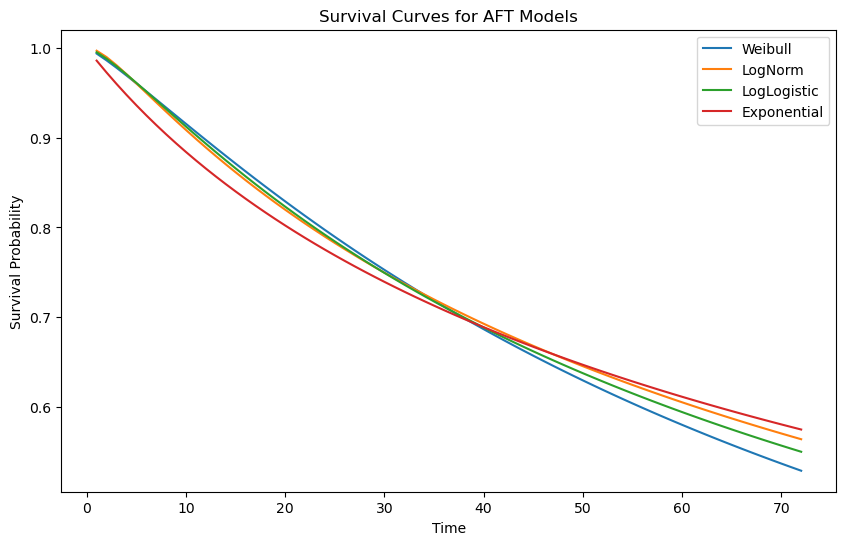

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(weibull_prediction_avg, label='Weibull')
plt.plot(lognormal_prediction_avg, label='LogNorm')
plt.plot(loglogistic_prediction_avg, label='LogLogistic')
plt.plot(exponential_prediction_avg, label='Exponential')

plt.title('Survival Curves for AFT Models')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

## Choosing & Building Optimal AFT Model

* Firstly, we saw that Log-Logistic and Log-Normal models displayed best performance in terms of **AIC/BIC** scores.
* In terms of **complexity**, the Exponential model is the simplest, assuming a constant hazard over time. The Weibull model adds flexibility by allowing for different hazard shapes. The Log-Normal and Log-Logistic models provide further flexibility in capturing various shapes of the survival curve. Choosing between these models often involves a trade-off between simplicity and the ability to capture complex patterns in the data.  
*Given the fact that we are working with a fairly small dataset, let's prioritize model performance and continue with **Log-Normal** model!*

### Log-Normal Model - All Auxiliary Features Included. 

In [33]:
lognormal_model.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.01
         time fit was run = 2023-11-26 21:52:15 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.07       2.90       0.17             0.73             1.40                 2.08                 4.06
       custcat_Plus service              0.92       2.52       0.22             0.50             1.35                 1.65                 3.85
       custcat_Total service             1.20       3.32       0.25             0.71             1.69                 2.03                 5.42
       ed_Did not complete high school   0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.32       1.37       0.16            -0.00             0.64                 1.00                 1.89
       ed_Post-undergraduate degree     -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.50
       ed_Some college                   0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
       forward_Yes                      -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.17
       gender_Male                       0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.77       0.46       0.14            -1.05            -0.49                 0.35                 0.61
       marital_Unmarried                -0.46       0.63       0.12            -0.68            -0.23                 0.51                 0.80
       region_Zone 2                    -0.10       0.91       0.14            -0.38             0.18                 0.69                 1.20
       region_Zone 3                     0.05       1.05       0.14            -0.23             0.33                 0.80                 1.38
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.43       0.65       0.17            -0.76            -0.10                 0.47                 0.90
       Intercept                         2.36      10.61       0.29             1.79             2.94                 5.98                18.84
sigma_ Intercept                         0.28       1.32       0.05             0.19             0.37                 1.20                 1.44

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    address                             0.00  4.78 <0.005      19.11
       age                                 0.00  4.50 <0.005      17.19
       custcat_E-service                   0.00  6.25 <0.005      31.21
       custcat_Plus service                0.00  4.29 <0.005      15.75
       custcat_Total service               0.00  4.79 <0.005  

### Log-Normal Model - Only Significant Auxiliary Features Included. 

*To determine significant variables, we must consider p_value. If a predictor variable has a p-value > alpha (= 0.05), it is considered non-significant and can be removed from the model.*

In [38]:
significant_features = lognormal_model.summary[lognormal_model.summary['p'] < 0.05].index
significant_features

MultiIndex([(   'mu_',               'address'),
            (   'mu_',                   'age'),
            (   'mu_',     'custcat_E-service'),
            (   'mu_',  'custcat_Plus service'),
            (   'mu_', 'custcat_Total service'),
            (   'mu_',          'internet_Yes'),
            (   'mu_',     'marital_Unmarried'),
            (   'mu_',             'voice_Yes'),
            (   'mu_',             'Intercept'),
            ('sigma_',             'Intercept')],
           names=['param', 'covariate'])

We can see that Age, Address, Customer Category, Internet and Voice Incuded, and Marital Status are the significant features.

In [39]:
final = data[['churn_Yes','tenure', 'address', 'age', 'marital_Unmarried','internet_Yes', 'voice_Yes', 
              'custcat_E-service','custcat_Plus service','custcat_Total service' ]]

In [40]:
logn_aft_final = LogNormalAFTFitter()
logn_aft_final.fit(final, duration_col='tenure', event_col='churn_Yes')
logn_aft_final_pd = logn_aft_final.predict_survival_function(final).transpose()
logn_aft_final.print_summary() 

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn_Yes'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.10
         time fit was run = 2023-11-26 21:55:23 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    address                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service       1.03       2.79       0.17             0.69             1.36                 2.00                 3.89
       custcat_Plus service    0.82       2.28       0.17             0.49             1.15                 1.63                 3.17
       custcat_Total service   1.01       2.75       0.21             0.60             1.42                 1.83                 4.15
       internet_Yes           -0.84       0.43       0.14            -1.11            -0.57                 0.33                 0.57
       marital_Unmarried      -0.45       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       voice_Yes              -0.46       0.63       0.17            -0.79            -0.14                 0.45                 0.87
       Intercept               2.53      12.62       0.24             2.06             3.01                 7.84                20.30
sigma_ Intercept               0.28       1.33       0.05             0.19             0.37                 1.21                 1.45

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    address                   0.00  4.84 <0.005      19.56
       age                       0.00  5.75 <0.005      26.78
       custcat_E-service         0.00  6.07 <0.005      29.53
       custcat_Plus service      0.00  4.85 <0.005      19.66
       custcat_Total service     0.00  4.83 <0.005      19.52
       internet_Yes              0.00 -6.08 <0.005      29.63
       marital_Unmarried         0.00 -3.91 <0.005      13.39
       voice_Yes                 0.00 -2.78   0.01       7.52
       Intercept                 0.00 10.45 <0.005      82.47
sigma_ Intercept                 0.00  6.15 <0.005      30.27
---
Concordance = 0.78
AIC = 2944.20
log-likelihood ratio test = 280.83 on 8 df
-log2(p) of ll-ratio test = 183.73

### Interpreting Coefficients
1.  For 'age' variable, an exp(coef) of 1.04 means that, for each additional unit increase in age, the hazard of the event (e.g., churn) is expected to increase by approximately 4% holding other variables constant.
2.  For 'address' variable, an exp(coef) of 1.04 means that, for each additional year living at the same address, the hazard of the event (e.g., churn) is expected to increase by approximately 4% holding other variables constant. 
3.  For 'internet_Yes' variable, an exp(coef) of 0.43 means that having internet included decreases the hazard of the event (e.g., churn) by approximately 57% holding other variables constant. 
4.  For 'voice_Yes' variable, an exp(coef) of 0.63 means that having voice included decreases the hazard of the event (e.g., churn) by approximately 37% holding other variables constant. 
5.  For 'marital_Unmarried' variable, an exp(coef) of 0.64 means that being unmarried decreases the hazard of the event (e.g., churn) by approximately 36% holding other variables constant.]
6. Basic Service is the reference category for the Customer Category variable. The exp(coef) of 'custcat_E-service'	is 2.79, which implies that, compared to the reference category (basic service), individuals with e-service are expected to have a hazard of the event (e.g., churn) that is approximately 2.79 times higher.  The exp(coef) of 'custcat_Plus-service' is 2.28, which implies that, compared to the reference category (basic service), individuals with e-service are expected to have a hazard of the event (e.g., churn) that is approximately 2.28 times higher.  The exp(coef) of 'custcat_Total-service' is 2.75, which implies that, compared to the reference category (basic service), individuals with e-service are expected to have a hazard of the event (e.g., churn) that is approximately 2.75 times higher.

*We can conclude that being older, living at the same address longer, not having internet or voice included, being married, not having a Basic Service Category elevate the churn risk.*

## CLV Calculation

In [46]:
calculate_clv(logn_aft_final_pd, df)
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn,CLV
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes,56448.497108
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes,57216.858575
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No,69263.303324
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes,45347.743264
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No,60174.077086


## Exploring CLV within different segments.

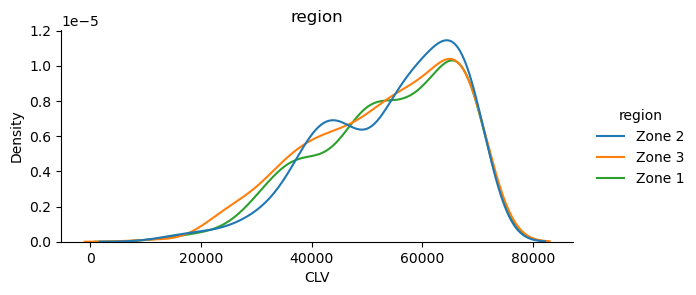

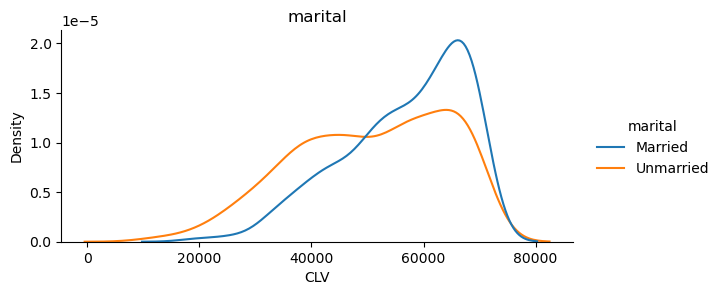

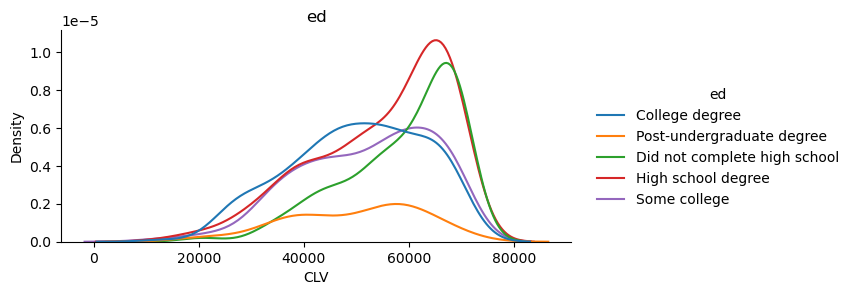

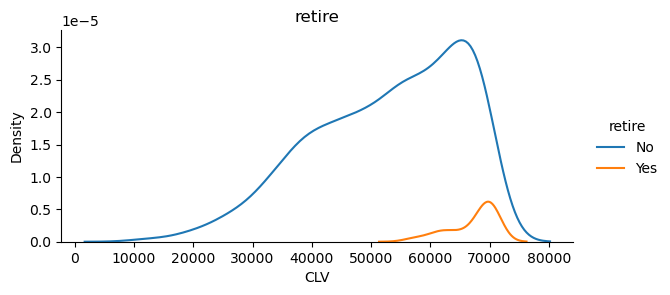

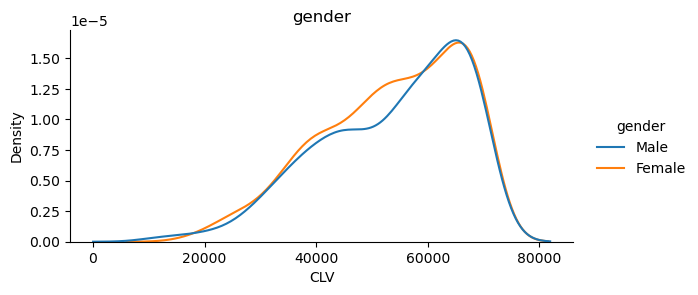

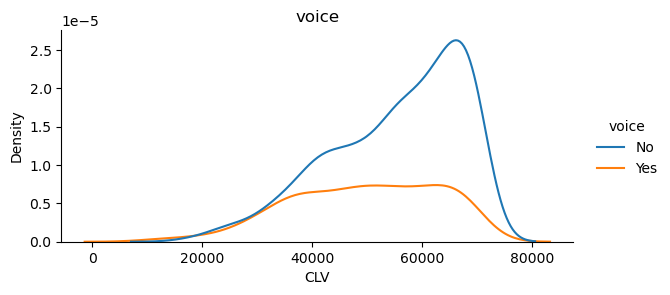

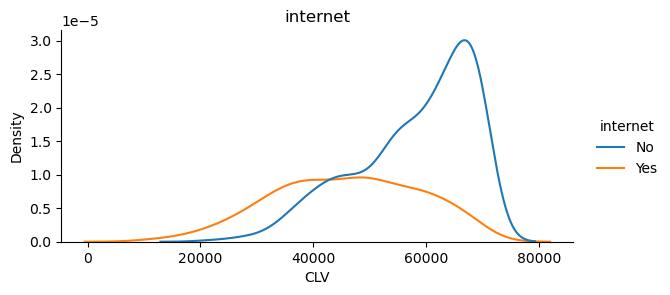

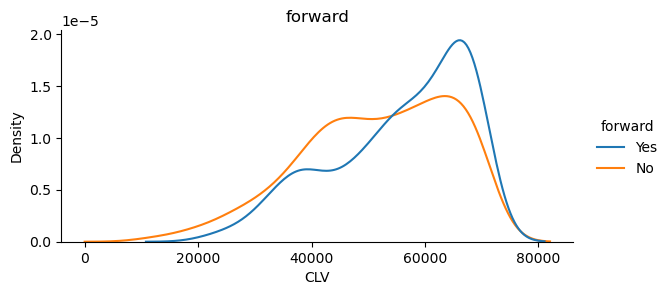

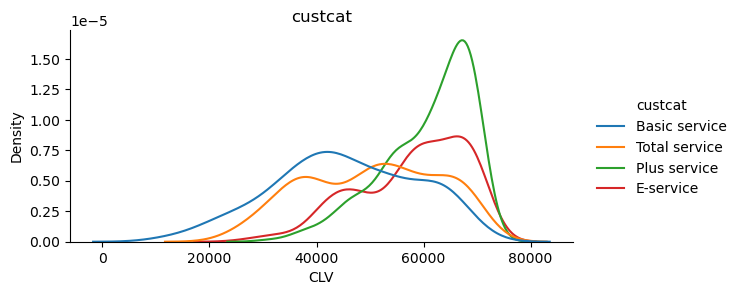

In [47]:
segments = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']
for column in segments:
    sns.displot(df, kind='kde', x='CLV', hue=column, height = 3, aspect = 2)
    plt.title(column)

In [48]:
for col in segments:
    print(df.groupby(col)[["CLV"]].mean())


                 CLV
region              
Zone 1  53697.944538
Zone 2  54239.022483
Zone 3  52859.165079
                    CLV
marital                
Married    56640.311122
Unmarried  50600.337490
                                       CLV
ed                                        
College degree                50051.152260
Did not complete high school  58707.520724
High school degree            54812.427384
Post-undergraduate degree     49664.179594
Some college                  52118.746741
                 CLV
retire              
No      52914.802868
Yes     67283.346910
                 CLV
gender              
Female  53464.459049
Male    53724.635837
                CLV
voice              
No     55348.100197
Yes    49565.285200
                   CLV
internet              
No        58063.098452
Yes       45908.277761
                  CLV
forward              
No       51608.256568
Yes      55628.272531
                        CLV
custcat                    
Basic service 

### Important Findings

Let's consider the most valuable segments as those contributing the highest average Customer Lifetime Value (CLV) to the company.

1. Retired customers emerge as particularly valuable, having a significantly higher average CLV than non-retired customers. Although constituting a smaller portion of our customer base, their elevated CLV positions them as high-value customers worthy of strategic attention.

2. The second-highest average CLV is attributed to customers utilizing the Plus Service. However, despite their financial contribution, it's noteworthy that they exhibit a higher likelihood of churning compared to Basic Service customers (as displayed by model coefficients). This highlights the importance of focusing efforts on retaining Plus Service customers, given their value and vulnerability.

3. Customers who did not complete high school claim the third position in terms of average CLV. 

The elevated CLV associated with Plus Service customers aligns with their higher expenditures for additional features and enhanced service. Regarding the other two segments, these findings may be linked to the higher demands that more educated or younger individuals have from a telecom company.

### Retention Budget Calculation

Let's consider the customer's who have not churned yet our at-risk customers.

In [49]:
retained_customers = df[df['churn'] == 'No']
at_risk_subscribers = len(retained_customers)

#let's see on average CLV the retained customers can generate in their entire lifetime.
retained_clv = retained_customers['CLV'].mean()
retained_clv 

56352.999618228845

Let's compute the annual budget.

In [50]:
#assume our goal is to retain 85% of at-risk customers
retention_rate = 0.85 

#assume we are prepared to pay 0.25 percent of the each customers CLV to retain them
cost_per_customer = retained_clv * 0.25

retention_budget = at_risk_subscribers * retention_rate * cost_per_customer
print(f'Yearly Retention Budget: {retention_budget}')

Yearly Retention Budget: 8693859.016102256


### Retention Strategies

* Implement loyalty programs, offering rewards and exclusive perks to long-term subscribers, fostering a sense of value and appreciation.
* Regularly communicate with customers through targeted and engaging content, informing them about new features, promotions, and benefits. 
* Utilize data analytics to identify potential churn indicators and proactively address issues before they escalate. 
* Consider flexible subscription plans, ensuring that offerings align with evolving customer needs.
* Finally, actively seek and act upon customer feedback, demonstrating a commitment to continuous improvement and a customer-centric approach.